# Helmholtz 1D Multilevel: Constant Aggregate Size 
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.

In [214]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.7

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
num_test_examples = 5

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
Kac   conv 0.91 shrinkage 0.63 PODR RER 0.62 after  5 sweeps. Work  1 efficiency 0.63
GS    conv 0.81 shrinkage 0.45 PODR RER 0.33 after  4 sweeps. Work  1 efficiency 0.45
kh 0.5
Kac   conv 0.95 shrinkage 0.65 PODR RER 0.44 after  6 sweeps. Work  1 efficiency 0.65
GS    conv 1.21 shrinkage 0.46 PODR RER 0.43 after  3 sweeps. Work  1 efficiency 0.46


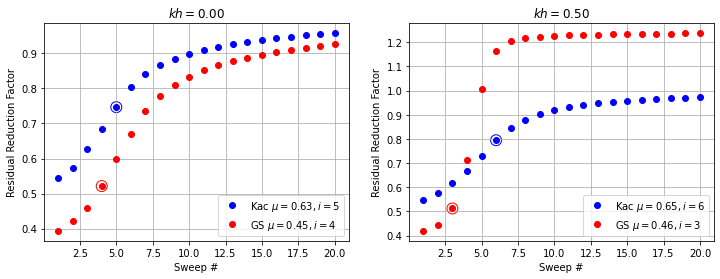

In [216]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [217]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)

In [218]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.7
INFO     Relax at level 0 size 96
INFO     Relax conv 0.94 shrinkage 0.66 PODR RER 0.67 after 5 sweeps. Work 1.0 eff 0.66
INFO     Generating TVs with 5 sweeps
INFO     RER 0.570


In [219]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 6, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values)
r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

kh 0.70 R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.2337; mock cycle nu 3 conv 0.20 efficiency 0.77


In [220]:
info = coarsener.get_coarsening_info(1)
columns=("i", "a", "nc", "cr", "Energy Error", "nu", "conv", "work", "eff")
pd.DataFrame(info).rename(columns=dict(enumerate(columns))).astype(
    {"i": "int32", "a": "int32", "nc": "int32", "nu": "int32"})

,i,a,nc,cr,Energy Error,nu,conv,work,eff
0,0,2,1,0.500000,0.357899,1,0.636557,2.000000,0.797845
1,0,2,1,0.500000,0.357899,2,0.351943,4.000000,0.770226
2,0,2,1,0.500000,0.357899,3,0.241400,6.000000,0.789083
3,0,2,1,0.500000,0.357899,4,0.267852,8.000000,0.848178
4,0,2,1,0.500000,0.357899,5,0.268225,10.000000,0.876698
5,1,4,1,0.250000,0.596332,1,0.866543,1.333333,0.898137
6,1,4,1,0.250000,0.596332,2,0.868297,2.666667,0.948420
7,1,4,1,0.250000,0.596332,3,0.863242,4.000000,0.963903
8,1,4,1,0.250000,0.596332,4,0.868019,5.333333,0.973810
9,1,4,1,0.250000,0.596332,5,0.842766,6.666667,0.974666


The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [221]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.959 asymptotic RQ -0.016 RER 0.149 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.1233; mock cycle nu 3 conv 0.19 eff 0.76
INFO     Mock cycle conv factor [0.627 0.319 0.186 0.122 0.147]
INFO     P max error: fit 0.285 val 1.444 test 0.283; alpha mean 0.024
INFO     fit  set size 15 P L2 error mean 0.05 max 0.07 A error mean 0.11 max 0.16
INFO     test set size 5  P L2 error mean 0.06 max 0.08 A error mean 0.15 max 0.20
INFO     Level 1 size 48
INFO     RER 0.241630
INFO     --------------------------------------------------------------------------------


### Level 1 Relaxation Shrinkage Factor

In [222]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

The coarse-level relaxation is still a good smoother, even though less effective than the fine-level relaxation. This means we built reasonable coarse-level equations that can be solved without advanced relaxation design techniques.

### Relaxation Cycle Shrinkage
We compare a two-level relaxation cycle with $\nu_1=1, \nu_2=1, \nu_{coarse}=$ # relaxations until the coarse-level relaxation slows down, with fine-level Kaczmarz relaxation.

2
INFO     Iter     |r|                 |x|         RER
INFO     0     1.176e+00            4.471e-01    2.634
INFO     1     6.661e-01 (0.566)    3.528e-01    1.902 (0.719)
INFO     2     4.010e-01 (0.603)    3.071e-01    1.323 (0.694)
INFO     3     2.565e-01 (0.640)    2.823e-01    0.923 (0.697)
INFO     4     1.803e-01 (0.703)    2.669e-01    0.685 (0.745)
INFO     5     1.374e-01 (0.762)    2.559e-01    0.543 (0.795)
INFO     6     1.133e-01 (0.823)    2.473e-01    0.462 (0.851)
INFO     7     9.793e-02 (0.862)    2.402e-01    0.411 (0.888)
INFO     8     8.729e-02 (0.889)    2.340e-01    0.376 (0.913)
INFO     9     7.928e-02 (0.907)    2.286e-01    0.350 (0.929)
INFO     10    7.303e-02 (0.921)    2.236e-01    0.330 (0.942)
INFO     11    6.804e-02 (0.932)    2.192e-01    0.314 (0.952)
INFO     Relax conv 0.93 shrinkage 0.68 PODR RER 0.46 after 6 sweeps. Work 1.0 eff 0.68
INFO     Iter     |r|                 |x|         RER
INFO     0     1.222e+00            4.465e-01    2.733

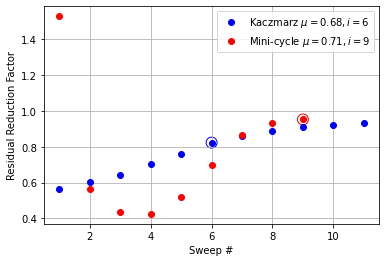

In [247]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=1, nu_post=1, nu_coarsest=nu_coarsest)

#### Observations
* The first cycle increases the residual! Unless enough relaxations (4) are performed at the finest level.
* Convergence is faster than relaxation ($0.4$ vs. $0.6$) until the slowdown.
* The RER at the PODR is a lot smaller than in relaxation.

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [249]:
num_examples = 20
max_levels = 2
num_bootstrap_steps = 3

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     Relax at level 0 size 48
INFO     Relax conv 0.80 shrinkage 0.42 PODR RER 0.27 after 2 sweeps. Work 1.0 eff 0.42
INFO     Generating TVs with 2 sweeps
INFO     RER 0.291
INFO     bootstrap on grid size 48 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.995 asymptotic RQ -0.028 RER 0.039 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (24, 48) a 6 nc 3 cr 0.50 mean_energy_error 0.0551; mock cycle nu 1 conv 0.27 eff 0.52
INFO     Mock cycle conv factor [0.276 0.109 0.065 0.051 0.034]
INFO     P max error: fit 0.039 val 1.209 test 0.066; alpha mean 0.001
INFO     fit  set size 15 P L2 error mean 0.01 max 0.03 A error mean 0.01 max 0.01
INFO     test set size 5  P L2 error mean 0.02 max 0.03 A error mean 0.01 max 0.02
INFO     Level 1 size 24
INFO     RER 0.086148
INFO     -----------------------------------

### Level 2 Relaxation Shrinkage

Level size 24
INFO     Iter     |r|                 |x|         RER
INFO     0     4.419e-01            4.451e-01    1.026
INFO     1     1.490e-01 (0.373)    3.419e-01    0.450 (0.492)
INFO     2     1.188e-01 (0.910)    3.138e-01    0.383 (0.986)
INFO     3     9.737e-02 (0.862)    3.003e-01    0.330 (0.901)
INFO     4     8.194e-02 (0.830)    2.904e-01    0.286 (0.860)
INFO     5     7.129e-02 (0.863)    2.826e-01    0.254 (0.888)
INFO     6     6.309e-02 (0.884)    2.763e-01    0.229 (0.905)
INFO     7     5.665e-02 (0.900)    2.712e-01    0.209 (0.918)
INFO     8     5.155e-02 (0.913)    2.669e-01    0.193 (0.928)
INFO     9     4.741e-02 (0.923)    2.632e-01    0.180 (0.936)
INFO     10    4.396e-02 (0.931)    2.600e-01    0.168 (0.942)
INFO     11    4.106e-02 (0.937)    2.572e-01    0.158 (0.947)
INFO     12    3.858e-02 (0.943)    2.547e-01    0.150 (0.952)
INFO     13    3.646e-02 (0.948)    2.524e-01    0.143 (0.957)
INFO     14    3.462e-02 (0.953)    2.503e-01    0.137 (0.

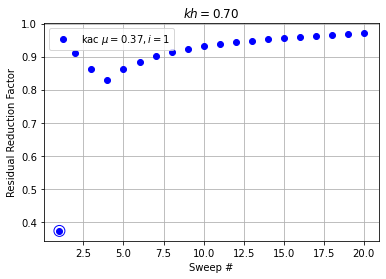

In [253]:
level = multilevel.level[1]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

2
INFO     Iter     |r|                 |x|         RER
INFO     0     2.617e-01            4.466e-01    0.587
INFO     1     1.111e-01 (0.425)    2.806e-01    0.399 (0.678)
INFO     2     5.570e-02 (0.504)    2.134e-01    0.269 (0.672)
INFO     3     3.708e-02 (0.666)    1.825e-01    0.210 (0.785)
INFO     4     2.698e-02 (0.724)    1.644e-01    0.171 (0.810)
INFO     5     2.133e-02 (0.788)    1.524e-01    0.146 (0.855)
INFO     6     1.789e-02 (0.835)    1.436e-01    0.130 (0.890)
INFO     7     1.563e-02 (0.868)    1.367e-01    0.118 (0.916)
INFO     8     1.399e-02 (0.889)    1.310e-01    0.110 (0.931)
INFO     9     1.272e-02 (0.902)    1.261e-01    0.103 (0.939)
INFO     10    1.169e-02 (0.911)    1.218e-01    0.097 (0.944)
INFO     11    1.082e-02 (0.918)    1.180e-01    0.092 (0.948)
INFO     12    1.009e-02 (0.924)    1.146e-01    0.087 (0.952)
INFO     Relax conv 0.79 shrinkage 0.46 PODR RER 0.27 after 2 sweeps. Work 1.0 eff 0.46
INFO     Iter     |r|                 |x|    

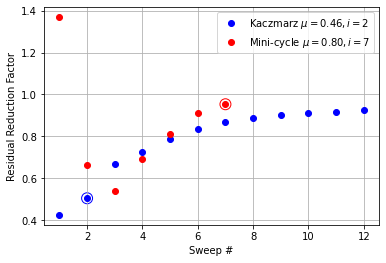

In [254]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, max_sweeps=100,
    nu_pre=1, nu_post=1, nu_coarsest=3)

* Level 2 relaxation behaves weirdly: it slows down after exactly one sweep. One sweep is fast, then the residual reduction goes up, then down, then slowly back up again.
* The Level 1-2 min-cycle is not more efficient.